![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Modelo Baseline de Regresión Lineal



# *1. Librerías y configuración*

In [2]:
# Principales

import pandas as pd
import numpy as np
# visuzalizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import learning_curve


import gc

In [3]:
pd.set_option('display.max_info_columns',110 )
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',80)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# *2. Funciones*

In [4]:
#Funcion que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    boolean_columns=[col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numeric_cols=int_columns + float_columns
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))

    # Cuento el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)
    return boolean_columns,numeric_cols,cat_columns,object_columns,other_columns

In [5]:

def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir.
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False.

    Returns
    -------
    pd.DataFrame
        Dataframe optimizado.
    """

    start_mem = df.memory_usage().sum() / 1024**2  # Memoria inicial

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                # Conversión de float a int si no hay decimales y no hay NaN
                df[col] = df[col].fillna(0)  # Rellenar NaN antes de verificar si son enteros
                if all(df[col].apply(float.is_integer)):
                    df[col] = df[col].astype(np.int64)

        # Conversión de objetos a categoría si turn_cat es True
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Memoria final

    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


# *3. Carga de datos*

In [6]:
df= pd.read_csv('./data/dfbaseline_sin_process.csv',index_col=False,low_memory=False)


# *4. Exploración*

In [7]:
df.shape

(9868, 96)

Eliminamos si existieran las columnas duplicadas

In [8]:
df = df.loc[:, ~df.columns.duplicated()]


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9868 entries, 0 to 9867
Data columns (total 96 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   url                                        9868 non-null   object 
 1   m2_constr                                  9868 non-null   float64
 2   distrito                                   9868 non-null   object 
 3   cod_distrito                               9868 non-null   int64  
 4   barrio                                     9868 non-null   object 
 5   cod_barrio                                 9868 non-null   int64  
 6   letra_ce                                   2124 non-null   object 
 7   tipologia                                  9868 non-null   object 
 8   estado                                     5507 non-null   object 
 9   amueblado                                  1182 non-null   object 
 10  planta                  

## *4.1. Eliminación columnas con 80% nulos*

Identificamos las columnas con mas de un 80% de los valores nulos y los eliminamos

In [11]:
# Identificamos las columnas con más del 85% de valores nulos
for col in df.columns:
    porcentaje_nulos = df[col].isnull().mean() * 100
    if porcentaje_nulos > 80:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna amueblado: 88.02% nulos
Columna balcon: 85.81% nulos
Columna garaje: 80.26% nulos
Columna tipo_inmueble: 80.92% nulos
Columna armarios: 87.45% nulos
Columna tipo_suelo: 86.54% nulos
Columna gastos_comunidad: 94.64% nulos
Columna agua_caliente: 93.03% nulos


In [12]:
# Definir el umbral de nulos (85%)
umbral_nulos = 0.80
# Calcular el porcentaje de nulos por columna
porcentaje_nulos = df.isnull().mean()
# Filtrar y eliminar columnas con más del 85% de nulos
df = df.loc[:, porcentaje_nulos <= umbral_nulos]



In [13]:
df.precio.describe()

count       9868.00
mean      887587.07
std      1149757.55
min        54000.00
25%       239000.00
50%       475000.00
75%      1090000.00
max     19950000.00
Name: precio, dtype: float64

## *4.2. Agrupación viviendas por precio promedio barrio*

Generamos una variable  mediante la agrupación de códigos de barrio, calculando el precio promedio por barrio,clasificando codigo de barrio en cinco grupos distintos en función de sus precios promedio relativos.
Realizamos esto por que consideramos que las viviendas ubicadas en el mismo barrio tienden a tener precios similares.

In [14]:
# Calcular el precio promedio por barrio
codbarrio_precios = df.groupby('cod_barrio')['precio'].mean().reset_index()

# Clasificar los códigos de barrio en cinco grupos y obtener los límites de los intervalos
codbarrio_precios['cod_barrio_group'], bins = pd.qcut(
    codbarrio_precios['precio'], q=5, labels=[1, 2, 3, 4, 5], retbins=True
)

# Crear un diccionario de mapeo para asignar grupos a cada barrio en el DataFrame original
cod_barrio_mapping = dict(zip(codbarrio_precios['cod_barrio'], codbarrio_precios['cod_barrio_group']))
df['cod_barrio_group'] = df['cod_barrio'].map(cod_barrio_mapping)

# Contar viviendas por grupo
cod_barrio_group_counts = df["cod_barrio_group"].value_counts(dropna=False).sort_index()

# Descripciones de los grupos con rangos de precios
descriptions = {
    1: "las más baratas entre todas las categorías",
    2: "con precios moderadamente bajos en relación con los demás grupos",
    3: "con un rango de precios similar a las del Grupo 4",
    4: "más costosas que las del Grupo 2, pero aún no están entre las más caras",
    5: "las viviendas más caras en el conjunto de datos"
}

# Mostrar la descripción de cada grupo con su rango de precios
for i, (group, count) in enumerate(cod_barrio_group_counts.items()):
    lower_bound = bins[i]  # Límite inferior del grupo
    upper_bound = bins[i + 1]  # Límite superior del grupo
    print(
        f"Grupo {group}: Este grupo contiene {count} viviendas. "
        f"Rango de precios: {lower_bound:.2f} - {upper_bound:.2f}. "
        f"Estas viviendas son {descriptions.get(group, 'una descripción no especificada.')}"
    )


Grupo 1: Este grupo contiene 1600 viviendas. Rango de precios: 111940.91 - 232568.00. Estas viviendas son las más baratas entre todas las categorías
Grupo 2: Este grupo contiene 1207 viviendas. Rango de precios: 232568.00 - 334194.44. Estas viviendas son con precios moderadamente bajos en relación con los demás grupos
Grupo 3: Este grupo contiene 1322 viviendas. Rango de precios: 334194.44 - 590108.70. Estas viviendas son con un rango de precios similar a las del Grupo 4
Grupo 4: Este grupo contiene 2149 viviendas. Rango de precios: 590108.70 - 937714.29. Estas viviendas son más costosas que las del Grupo 2, pero aún no están entre las más caras
Grupo 5: Este grupo contiene 3590 viviendas. Rango de precios: 937714.29 - 3109250.00. Estas viviendas son las viviendas más caras en el conjunto de datos


In [15]:
codbarrio_precios.describe()

,cod_barrio,precio
count,131.00,131.00
mean,110.70,676912.60
std,58.91,620036.95
min,11.00,111940.91
25%,62.50,256213.67
50%,111.00,439243.16
75%,157.50,865059.22
max,215.00,3109250.00


## *4.3. Correlación*

Creo un dataset solo con las variables numericas , vemos la correlación entre las mismas y eliminamos una de las variables que tenga con otra
una correlación mayor del 90% para reducir la multicolinealidad y mejorar el rendimiento del modelo

In [16]:
# Seleccionar solo las columnas numéricas
df_numerico = df.select_dtypes(include=["number"])

# Calcular la matriz de correlación
correlation_matrix = df_numerico.corr()
# Calcular la matriz de correlación
#correlation_matrix = df.corr()

# Seleccionar las correlaciones superiores al 90% (excluyendo la diagonal)
correlated_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:  # Umbral del 90%
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlated_pairs.add((col1, col2))

# Elegir una columna de cada par para eliminar (por simplicidad, la segunda de cada par)
columns_to_drop = {pair[1] for pair in correlated_pairs}

# Eliminar las columnas correlacionadas
df_numerico = df_numerico.drop(columns=columns_to_drop)

# Mostrar las columnas eliminadas
print("Columnas eliminadas por alta correlación:", columns_to_drop)


Columnas eliminadas por alta correlación: {'hog_con_10', 'hog_con_1', 'num_personas_mujeres', 'hog_con_8', 'hog_con_5', 'num_personas_hombres', 'cultura_entretenimiento', 'cod_barrio', 'm2_utiles', 'hog_con_15_y_más', 'renta_bruta_media_por_hogar', 'servicios_profesionales', 'hog_con_7', 'hog_con_11', 'hog_con_3', 'renta_bruta_media_por_persona', 'hog_con_4', 'mediana_de_la_renta_por_unidad_de_consumo', 'renta_neta_media_por_hogar', 'hog_con_6', 'hog_con_9'}


Representación grafica de la matriz de correlación entre las varibles que quedan en el dataset

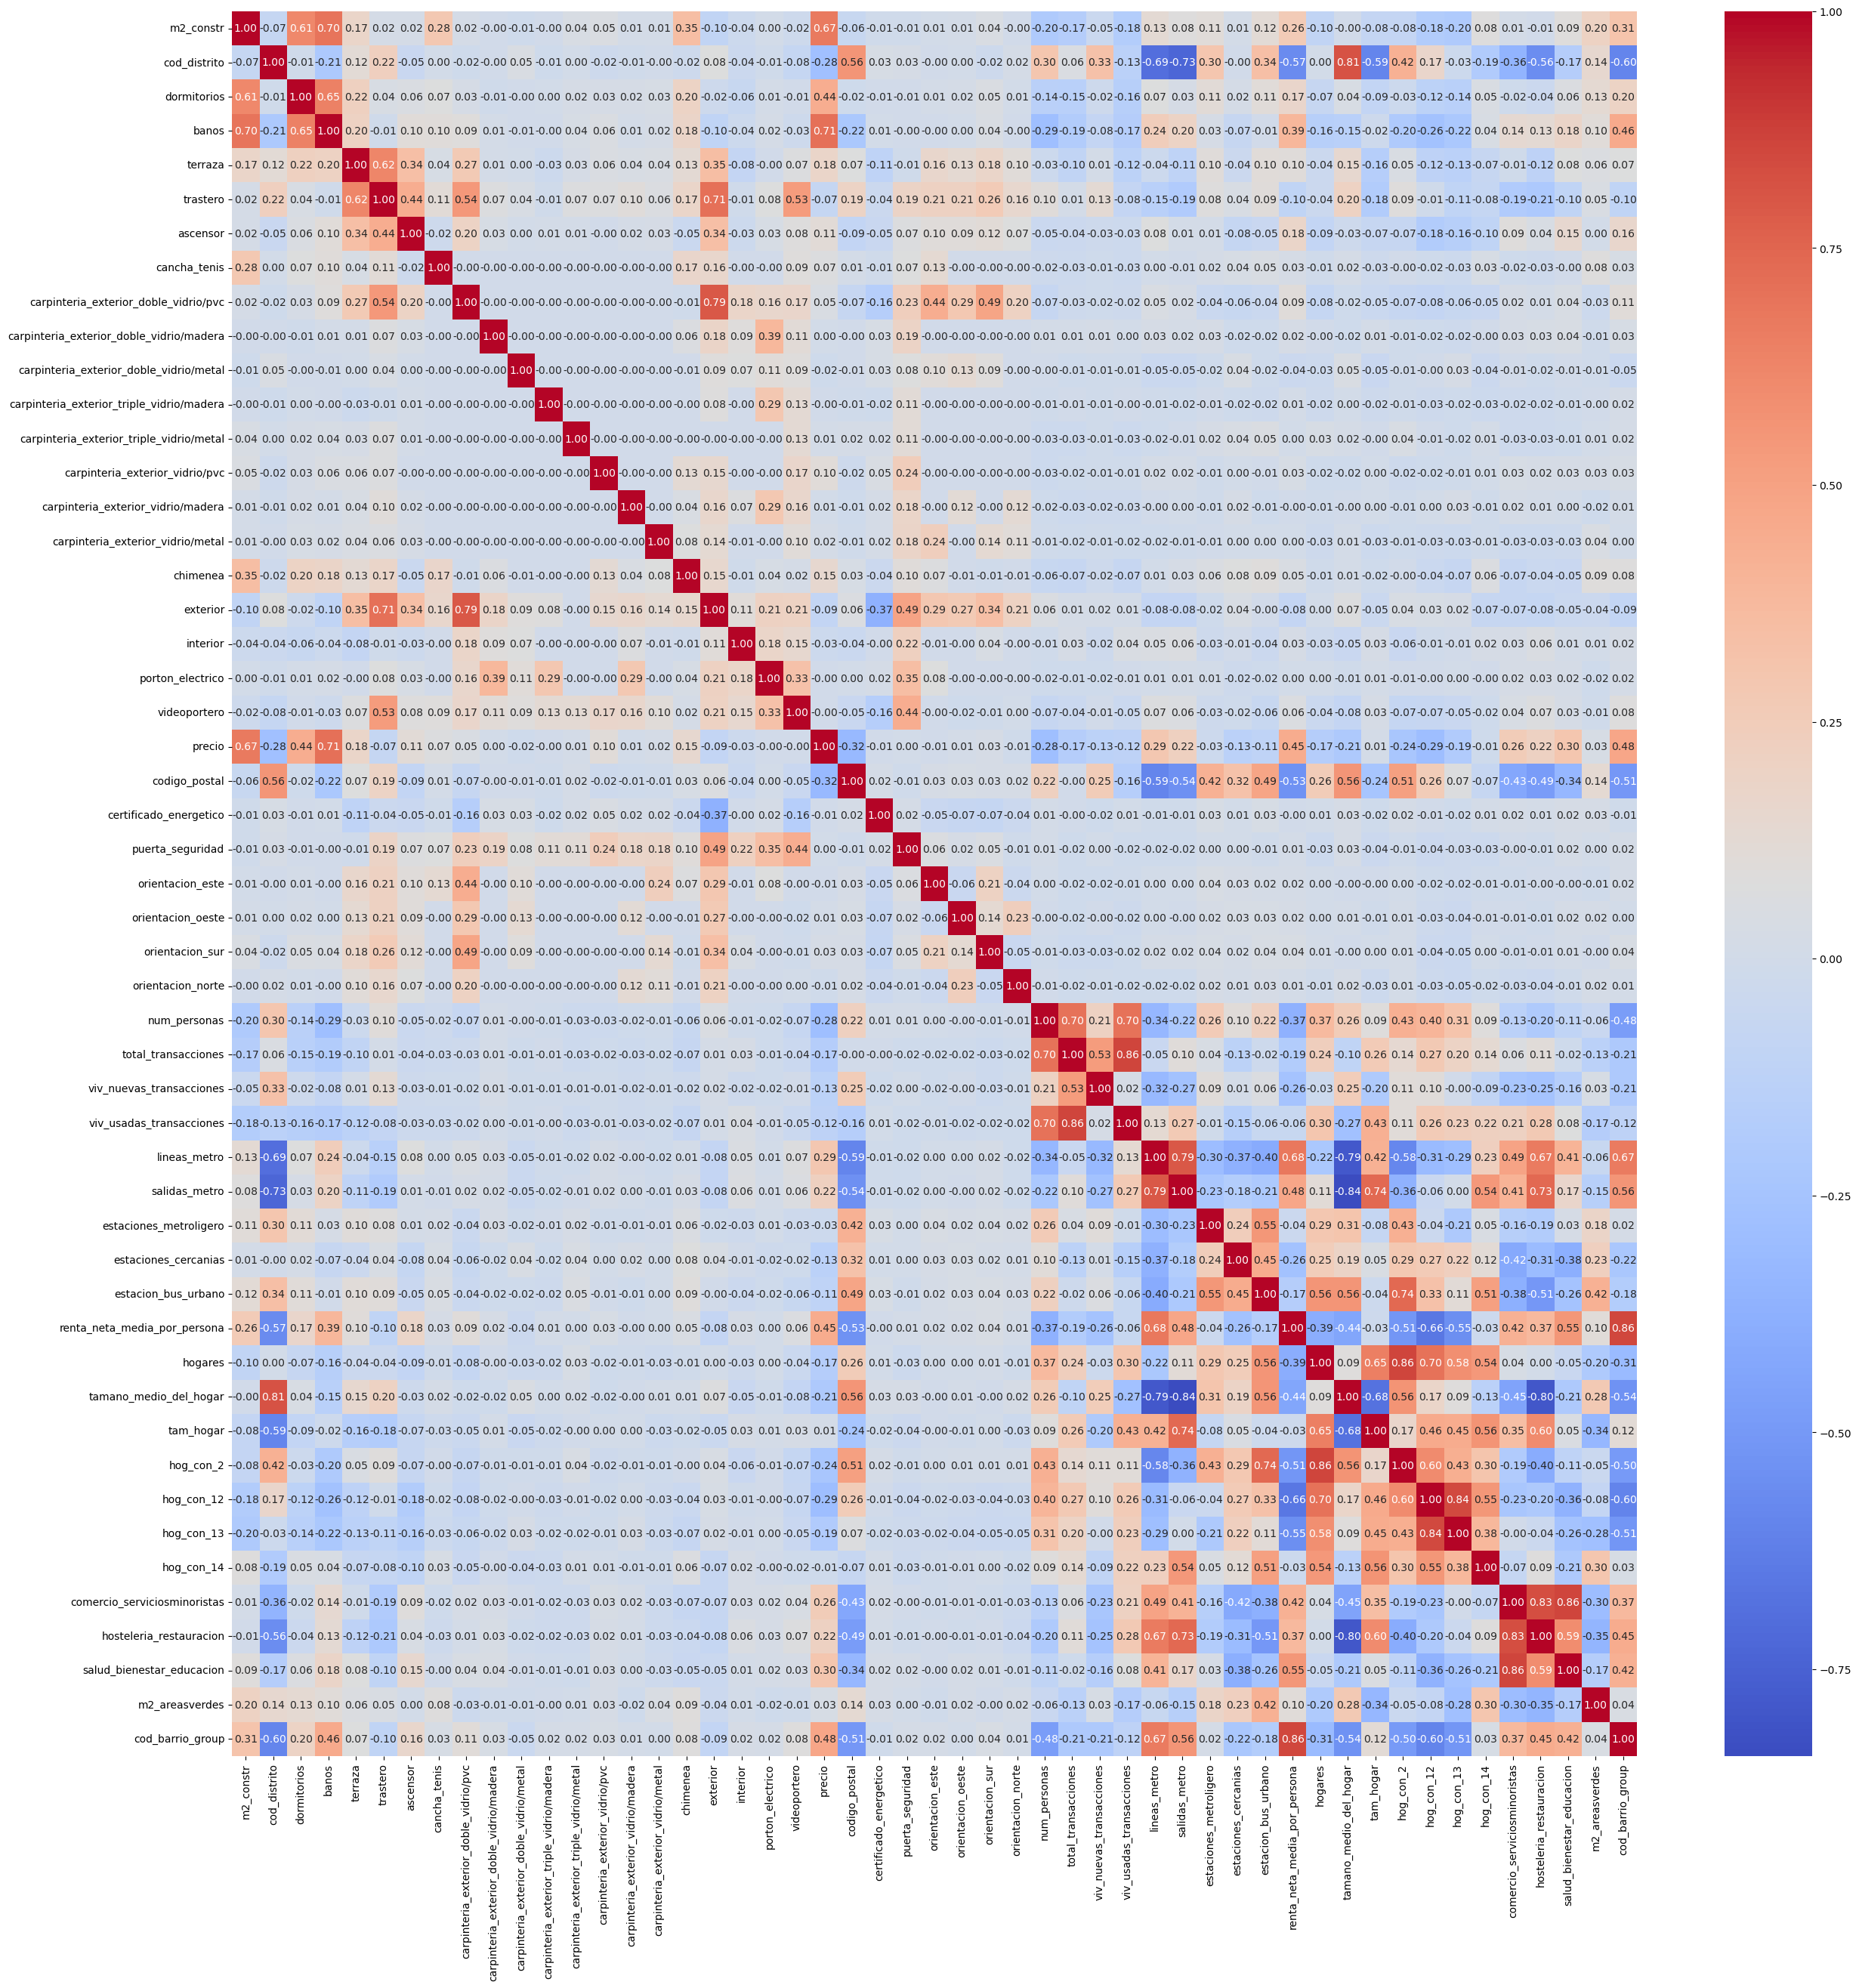

In [17]:

# Calcular la matriz de correlación
correlation_matrix = df_numerico.corr()

# Graficar el heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",cmap='coolwarm')
plt.show()


Se comprueba que no tenemos pares de variables con correlacción mayor al 90%

In [18]:
# Establecer un umbral para la correlación (90%)
threshold = 0.90

# Identificar pares de variables con correlación
correlations = []
already_seen = set()

for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if abs(correlation_matrix.loc[row, col]) > threshold and col != row:
            pair = tuple(sorted((row, col)))  # Crear pares únicos
            if pair not in already_seen:
                correlations.append((row, col, correlation_matrix.loc[row, col]))
                already_seen.add(pair)  # Marcar par como ya visto

# Imprimir los resultados
print("Pares de variables con correlación mayor al 90%:")
for var1, var2, corr in correlations:
    print(f"{var1} y {var2}: {corr:.2f}")


Pares de variables con correlación mayor al 90%:


Revisamos la correlacción de la variable target con el resto de variables númericas

In [ ]:
# Selecciona la fila correspondiente a 'precio'
corr_precio = correlation_matrix.loc['precio']

print(corr_precio)


m2_constr                                    0.67
cod_distrito                                -0.28
dormitorios                                  0.44
banos                                        0.71
terraza                                      0.18
trastero                                    -0.07
ascensor                                     0.11
cancha_tenis                                 0.07
carpinteria_exterior_doble_vidrio/pvc        0.05
carpinteria_exterior_doble_vidrio/madera     0.00
carpinteria_exterior_doble_vidrio/metal     -0.02
carpinteria_exterior_triple_vidrio/madera   -0.00
carpinteria_exterior_triple_vidrio/metal     0.01
carpinteria_exterior_vidrio/pvc              0.10
carpinteria_exterior_vidrio/madera           0.01
carpinteria_exterior_vidrio/metal            0.02
chimenea                                     0.15
exterior                                    -0.09
interior                                    -0.03
porton_electrico                            -0.00


# 5. Separación entre train y test

In [20]:
print(f"El DataFrame df_numericotiene {df_numerico.shape[0]} filas y {df_numerico.shape[1]} columnas.")

El DataFrame df_numericotiene 9868 filas y 51 columnas.


In [21]:
# Guardamos la  variable target en una variable "target"
target = 'precio'
df_numerico[target].head()

0   2000000.00
1    650000.00
2    625000.00
3   1300000.00
4   1900000.00
Name: precio, dtype: float64

Incluimos la columna url para crear df_ids para almacenar los identificadores de cada vivienda

In [ ]:
#Incluyo la columna url para crear df_ids para almacenar los identificadores de cada vivienda
dfbaseline=df_numerico
dfbaseline["url"] = df["url"]
print(dfbaseline['cod_barrio_group'].value_counts())


cod_barrio_group
5    3590
4    2149
1    1600
3    1322
2    1207
Name: count, dtype: int64


Procedemos a realizar la división del conjunto de datos

In [ ]:
# Dividir las columnas objetivo y características

y = dfbaseline['precio'].values  # Asegúrate de usar la columna correcta para 'cod_barrio_group'

df_ids = dfbaseline[['url']]
X = dfbaseline.drop(columns=['url','precio'])

# Primera clasificación entre train y test, estratificando por 'cod_barrio_group'
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, df_ids, test_size=0.2, random_state=42, stratify=X['cod_barrio_group'], shuffle=True
)

# Verificar la distribución de las clases en train y test
print("Distribución en el conjunto de entrenamiento:")


print(pd.Series(y_train).value_counts())
print("Distribución en el conjunto de test:")

print(pd.Series(y_test).value_counts())

# Segunda división: Train y Validación a partir de X_train, estratificando también
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=X_train['cod_barrio_group'], shuffle=True
)

# Verificar la distribución de las clases en train y validación
print("Distribución en el conjunto de validación:")

print(pd.Series(y_val).value_counts())
# Número de registros del dataset de train, test y validación
print("Número de observaciones")
print("- Train: ", X_train.shape[0])
print("- Test:  ", X_test.shape[0])
print("- Val:   ", X_val.shape[0])

# Resetear los índices para cada conjunto
dftrain = X_train.reset_index(drop=True)
dftest = X_test.reset_index(drop=True)
dfval = X_val.reset_index(drop=True)


Distribución en el conjunto de entrenamiento:
210000.00     51
240000.00     49
260000.00     49
230000.00     48
1200000.00    47
              ..
146300.00      1
92260.00       1
159500.00      1
3780000.00     1
7990000.00     1
Name: count, Length: 1426, dtype: int64
Distribución en el conjunto de test:
295000.00    17
220000.00    16
320000.00    16
330000.00    16
350000.00    14
             ..
649900.00     1
134000.00     1
70000.00      1
443000.00     1
107900.00     1
Name: count, Length: 739, dtype: int64
Distribución en el conjunto de validación:
230000.00    14
210000.00    13
260000.00    13
240000.00    13
220000.00    12
             ..
69000.00      1
287500.00     1
860000.00     1
588000.00     1
792000.00     1
Name: count, Length: 665, dtype: int64
Número de observaciones
- Train:  6315
- Test:   1974
- Val:    1579


## *5.1. Imputación de nulos*

Para realizar la imputación de nulos reamos un diccionario que alamacena las medias por grupo por cada columa con valores nulos

In [24]:
# Crear un diccionario para almacenar las medias por grupo (por cada columna)
medias_por_grupo = {}

# Calcular la media de cada columna en X_train agrupada por 'cod_barrio_group'
for columna in X_train.columns:
    if X_train[columna].isnull().sum() > 0:  # Solo calculamos si la columna tiene nulos
        # Agrupar por 'cod_barrio_group' y calcular la media de cada grupo
        medias_por_grupo[columna] = X_train.groupby('cod_barrio_group')[columna].mean().to_dict()

# Imputar valores nulos en X_train según las medias por grupo
X_train_imputado = X_train.copy()
for columna, medias in medias_por_grupo.items():
    # Imputar solo las filas que tienen nulos
    for grupo, media in medias.items():
        # Filtrar las filas por grupo y reemplazar los valores nulos con la media correspondiente
        X_train_imputado.loc[(X_train_imputado['cod_barrio_group'] == grupo) & (X_train_imputado[columna].isnull()), columna] = media

# Imputación en X_val y X_test (usando las mismas medias por grupo que en X_train)
X_val_imputado = X_val.copy()
X_test_imputado = X_test.copy()

for columna, medias in medias_por_grupo.items():
    for grupo, media in medias.items():
        # Imputar valores nulos en X_val y X_test
        X_val_imputado.loc[(X_val_imputado['cod_barrio_group'] == grupo) & (X_val_imputado[columna].isnull()), columna] = media
        X_test_imputado.loc[(X_test_imputado['cod_barrio_group'] == grupo) & (X_test_imputado[columna].isnull()), columna] = media

# Mostrar el DataFrame imputado para verificar
print(X_train_imputado.head())
print(X_val_imputado.head())
print(X_test_imputado.head())


      m2_constr  cod_distrito  dormitorios  banos  terraza  trastero  \
6033     560.00             1        10.00  10.00     1.00      0.46   
6713     182.00             7         3.00   2.00     0.82      0.47   
6292     270.00             1         4.00   5.00     1.00      1.00   
3852      79.00             6         3.00   1.61     0.70      0.66   
8858      67.00             9         3.00   1.00     0.70      0.46   

      ascensor  cancha_tenis  carpinteria_exterior_doble_vidrio/pvc  \
6033      1.00          0.00                                   0.09   
6713      0.94          0.00                                   0.15   
6292      0.94          0.00                                   0.15   
3852      0.91          0.00                                   0.08   
8858      1.00          0.00                                   0.09   

      carpinteria_exterior_doble_vidrio/madera  \
6033                                      0.00   
6713                                    

In [25]:
# Forzar la recolección de basura
gc.collect()

151104


## *5.2 Entrenamiento*

In [38]:
X_train=X_train_imputado
X_val=X_val_imputado
X_test=X_test_imputado
X_train = X_train.drop(columns=['cod_barrio_group'])
X_test = X_test.drop(columns=['cod_barrio_group'])
X_val = X_val.drop(columns=['cod_barrio_group'])


# Create a Linear regressor
lm = LinearRegression()

# 2. Inicializar RFE con el modelo y seleccionar las mejores 10 características
selector = RFE(lm, n_features_to_select=10)

# 3. Ajustar el selector a los datos de entrenamiento (esto realiza la selección)
selector = selector.fit(X_train, y_train)

# 4. Obtener las columnas seleccionadas
selected_columns = X_train.columns[selector.support_]

# 5. Imprimir las variables más importantes
print("Variables más importantes:", selected_columns)


# Train the model using the training sets
lm.fit(X_train, y_train)
# Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns, lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients['Absolute Coefficients'] = coeffcients['Coefficients'].abs()
coeffcients = coeffcients.sort_values(by='Absolute Coefficients', ascending=False)

coeffcients

Variables más importantes: Index(['banos', 'terraza', 'cancha_tenis',
       'carpinteria_exterior_doble_vidrio/madera',
       'carpinteria_exterior_triple_vidrio/madera',
       'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/metal',
       'chimenea', 'porton_electrico', 'tamano_medio_del_hogar'],
      dtype='object')


,Attribute,Coefficients,Absolute Coefficients
7,cancha_tenis,-4024885.89,4024885.89
39,tamano_medio_del_hogar,-1334514.85,1334514.85
12,carpinteria_exterior_triple_vidrio/metal,-1097614.97,1097614.97
13,carpinteria_exterior_vidrio/pvc,809149.22,809149.22
16,chimenea,-509572.86,509572.86
10,carpinteria_exterior_doble_vidrio/metal,-366855.88,366855.88
3,banos,307310.20,307310.20
18,interior,-245523.41,245523.41
14,carpinteria_exterior_vidrio/madera,216489.47,216489.47
19,porton_electrico,-185285.54,185285.54


## *5.3 Evaluación sobre train*

In [39]:
### 3.2 Evaluación sobre train

In [40]:
# Model prediction on train df
y_pred = lm.predict(X_train)
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.639518654632665
MAE: 341797.7830275171
MSE: 470113937610.64307
RMSE: 685648.5525476176


## *5.4 Evaluación sobre validación*

In [41]:
# Model prediction on val df
y_pred_val = lm.predict(X_val)
# Model Evaluation
print('R^2:',metrics.r2_score(y_val, y_pred_val))
print('MAE:',metrics.mean_absolute_error(y_val, y_pred_val))
print('MSE:',metrics.mean_squared_error(y_val, y_pred_val))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_val, y_pred_val)))

R^2: 0.6335422336545786
MAE: 347367.3565284886
MSE: 502323794065.6509
RMSE: 708748.0469572039


## *5.5 Evaluación sobre test*

In [42]:
# Predicting Test df with the model
y_test_pred = lm.predict(X_test)
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.6768260528599731
MAE: 330554.0496900265
MSE: 432693343364.6603
RMSE: 657794.3017119108


- **𝑅^2**: Es una medida de la relación lineal entre X e Y. Se interpreta como la proporción de la varianza en la variable dependiente que es predecible a partir de la variable independiente.

- **MAE**: Es la media del valor absoluto de los errores. Mide la diferencia entre dos variables continuas, en este caso, los valores reales y los valores predichos de y.

- **MSE**: El error cuadrático medio (MSE, por sus siglas en inglés) es similar al MAE, pero eleva al cuadrado la diferencia antes de sumarlas todas, en lugar de usar el valor absoluto.

- **RMSE**: La raíz cuadrada del error cuadrático medio (RMSE, por sus siglas en inglés) es la raíz cuadrada del MSE.

## *5.6 Interpretación grafica del modelo*

##### Precios reales vs Precios predichos (Train)

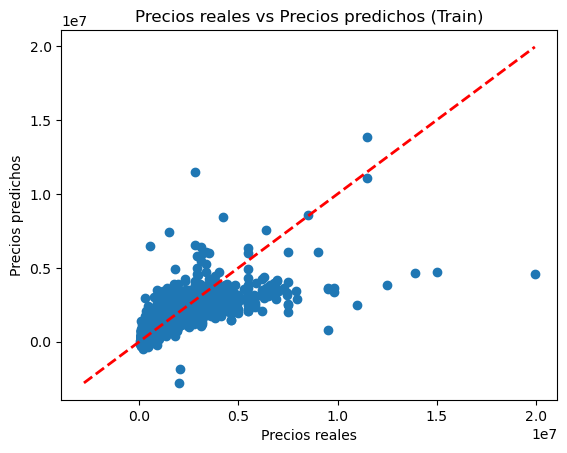

In [ ]:
# Scatter plot

plt.scatter(y_train, y_pred)
plt.xlabel("Precios reales")
plt.ylabel("Precios predichos")
plt.title("Precios reales vs Precios predichos (Train)")

# Línea ideal
min_val = min(y_train.min(), y_pred.min())  # Valor mínimo para la línea
max_val = max(y_train.max(), y_pred.max())  # Valor máximo para la línea
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

#plt.legend()
#plt.grid(True)
plt.show()


El gráfico representa una relación entre los precios reales y los precios predichos

   - Cada punto en el gráfico representa una observación individual (una vivienda).
   - Si el modelo fuera perfecto, todos los puntos estarían alineados sobre la línea diagonal, eso indicaria que las predicciones coinciden exactamente con los valores reales.
   - Sin embargo, en este caso, se observa una **dispersión considerable** alrededor de la diagonal. Esto indica que las predicciones del modelo tienen cierto grado de error.

   - El nivel de dispersión muestra como de bueno es el modelo calculando las prediciones de los precios. Tenemos Una dispersión alta, por lo que el modelo neesita ajuste. 
   - Algunas observaciones están muy alejadas de la diagonal, reflejando **predicciones especialmente incorrectas** 


##### Precios predichos  vs Residuales

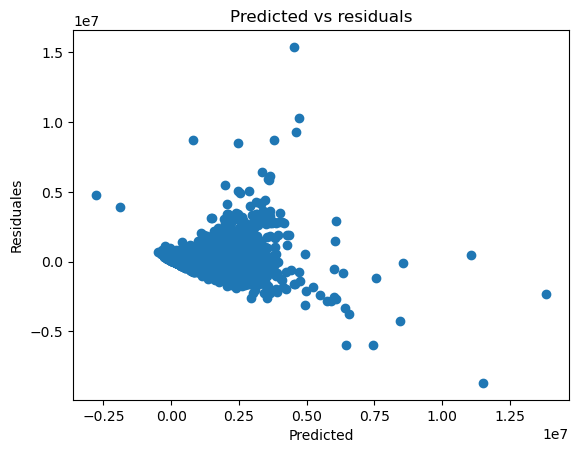

In [44]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuales")
plt.show()

##### Historgrama residuales

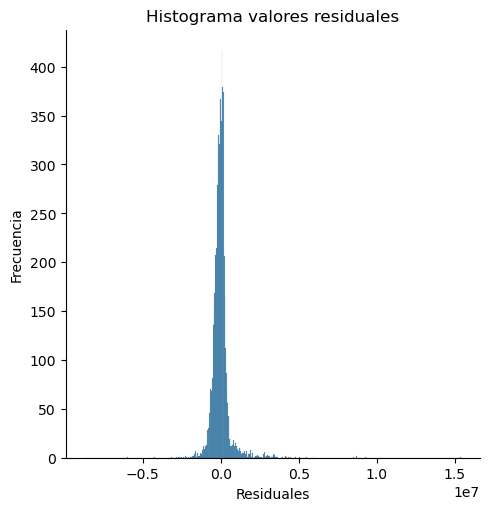

In [45]:
# Checking Normality of errors
sns.displot(y_train-y_pred)
plt.title("Histograma valores residuales")
plt.xlabel("Residuales")
plt.ylabel("Frecuencia")
plt.show()

El gráfico presenta una forma acampanada centrada en torno al valor cero, lo cual sugiere que los errores son simétricos y que no hay un sesgo claro en las predicciones del modelo.El modelo de regresión cumple con la suposición de normalidad de los errores, lo que permite asegurar la calidad y validez del modelo.

##### Outliers

Mostramos algunos de los valores outliers en la predición del conjunto de train

In [46]:
#Mostramos algunos de los valores outliers en la predición del conjunto de train

# Calcular errores (diferencias absolutas entre y_train y y_pred)
errores = pd.Series(np.abs(y_train - y_pred), index=X_train.index)

# Establecer el umbral para identificar outliers (e.g., 2 desviaciones estándar)
umbral = errores.mean() + 2 * errores.std()

# Identificar índices de los outliers
outliers_indices = errores[errores > umbral].index

# Extraer IDs de las observaciones consideradas como outliers
outliers_ids = ids_train.loc[outliers_indices]

# Mostrar los IDs de los outliers
print("IDs de los outliers:")
print(outliers_ids)

# (Opcional) Extraer también las características de los outliers
outliers_X = X_train.loc[outliers_indices]
print("Características de los outliers:")
print(outliers_X)


IDs de los outliers:
                                                                                 url
1397                                       https://www.indomio.es/anuncios/96517349/
5057      https://www.pisos.com/comprar/piso-cortes_huertas28014-48342842585_100500/
2617                                       https://www.indomio.es/anuncios/96840943/
4103           https://www.pisos.com/comprar/piso-recoletos28009-30839507776_996542/
3143  https://www.pisos.com/comprar/casa_adosada-penagrande28035-32536641805_100500/
...                                                                              ...
7592       https://www.pisos.com/comprar/atico-nueva_espana28036-24261975323_101800/
3640     https://www.pisos.com/comprar/piso-justicia_chueca28046-37595993029_102100/
257                                        https://www.indomio.es/anuncios/94471865/
698                                        https://www.indomio.es/anuncios/95859037/
1518                                       h

In [47]:
outliers_X.describe()

,m2_constr,cod_distrito,dormitorios,banos,terraza,trastero,ascensor,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,exterior,interior,porton_electrico,videoportero,codigo_postal,certificado_energetico,puerta_seguridad,orientacion_este,orientacion_oeste,orientacion_sur,orientacion_norte,num_personas,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,renta_neta_media_por_persona,hogares,tamano_medio_del_hogar,tam_hogar,hog_con_2,hog_con_12,hog_con_13,hog_con_14,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,m2_areasverdes
count,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00,189.00
mean,546.74,5.22,4.77,4.56,0.86,0.42,0.93,0.02,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.37,0.01,0.00,0.09,28012.91,0.12,0.03,0.06,0.07,0.12,0.02,17623.70,232.90,14.09,218.81,6.01,18.15,0.39,1.35,219.67,25798.30,64138.80,2.32,24216.68,9884.75,10.84,7.46,37.18,1598.63,792.46,588.98,2308922.17
std,496.09,3.69,2.13,1.74,0.13,0.37,0.19,0.13,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.40,0.01,0.00,0.19,14.39,0.33,0.07,0.23,0.25,0.33,0.14,9194.04,122.37,30.51,112.68,1.59,5.23,1.14,1.20,81.24,3542.70,10298.28,0.20,5564.72,2469.09,5.61,3.04,11.80,846.17,391.23,377.16,5585958.33
min,100.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28001.00,0.00,0.00,0.00,0.00,0.00,0.00,1622.00,17.00,0.00,16.00,2.00,8.00,0.00,0.00,138.00,12764.00,47279.00,1.99,14738.00,8103.00,0.00,2.00,13.00,197.00,95.00,137.00,19677.00
25%,301.00,4.00,4.00,3.00,0.82,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28001.00,0.00,0.00,0.00,0.00,0.00,0.00,15444.00,186.00,3.00,180.00,6.00,14.00,0.00,1.00,181.00,21947.00,62667.00,2.28,20435.00,8613.00,8.00,4.00,30.00,693.00,274.00,169.00,223280.00
50%,389.00,4.00,4.00,5.00,0.82,0.47,0.94,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.44,0.00,0.00,0.09,28009.00,0.00,0.02,0.00,0.00,0.00,0.00,16919.00,243.00,8.00,235.00,6.00,18.00,0.00,1.00,186.00,27076.00,63877.00,2.28,24741.00,9580.00,8.00,9.00,30.00,1930.00,1051.00,928.00,333527.00
75%,643.00,7.00,5.00,5.00,1.00,0.47,1.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.47,0.01,0.01,0.10,28015.00,0.00,0.04,0.00,0.00,0.00,0.00,19418.00,289.00,9.00,276.00,7.00,20.00,0.00,2.00,275.00,28140.00,68311.00,2.45,25648.00,9580.00,13.00,9.00,48.00,2470.00,1051.00,928.00,995950.00
max,4574.00,20.00,15.00,12.00,1.00,1.00,1.00,1.00,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,1.00,1.00,0.02,0.01,1.00,28055.00,1.00,1.00,1.00,1.00,1.00,1.00,69176.00,750.00,262.00,741.00,9.00,27.00,6.00,5.00,448.00,30506.00,98591.00,2.67,34155.00,18298.00,32.00,17.00,59.00,2470.00,1116.00,1039.00,19901426.00


In [48]:
#Hacemos el mismo estudio de los outliers en el conjunto de validación
# Calcular errores (diferencias absolutas entre y_train y y_pred)
errores = pd.Series(np.abs(y_val - y_pred_val), index=X_val.index)

# Establecer el umbral para identificar outliers (e.g., 2 desviaciones estándar)
umbral = errores.mean() + 2 * errores.std()

# Identificar índices de los outliers
outliers_indices = errores[errores > umbral].index

# Extraer IDs de las observaciones consideradas como outliers
outliers_ids = ids_train.loc[outliers_indices]

# Mostrar los IDs de los outliers
print("IDs de los outliers:")
print(outliers_ids)

# (Opcional) Extraer también las características de los outliers
outliers_X = X_val.loc[outliers_indices]
print("Características de los outliers:")
print(outliers_X)

IDs de los outliers:
                                                                                               url
2756                                                     https://www.indomio.es/anuncios/96873051/
2619                                                     https://www.indomio.es/anuncios/96841699/
4091                         https://www.pisos.com/comprar/piso-recoletos28001-34223633996_100500/
2343                                                     https://www.indomio.es/anuncios/96786101/
5884              https://www.pisos.com/comprar/piso-salamanca_castellana28006-40067391253_149200/
6384                         https://www.pisos.com/comprar/piso-jeronimos28009-40854699641_100500/
605                                                      https://www.indomio.es/anuncios/95678285/
280                                                      https://www.indomio.es/anuncios/94713271/
2991  https://www.pisos.com/comprar/apartamento-moncloa_aravaca_arguelles28008-483347384

In [53]:

# Supongamos que ya tienes estas variables:
# X_test: conjunto de características para datos de prueba
# y_test: valores reales de la variable objetivo (como precios reales)
# y_pred: predicciones del modelo sobre X_test

# Añade 'y_test' (valores reales) y 'y_pred' (predicciones) al DataFrame
df = X_test.copy()  # Copiamos X_test para no modificarlo directamente
df['y_test'] = y_test  # Agregamos los valores reales
df['y_pred'] =y_test_pred  # Agregamos las predicciones del modelo

# Asegúrate de que las columnas relevantes estén en X_test
# Si 'm2_constr' y 'district' ya están en X_test, no es necesario hacer nada adicional.
# De lo contrario, verifica que esos datos estén accesibles y agrégalos al DataFrame.

# Verificar que las columnas necesarias están en el DataFrame
if 'm2_constr' not in df.columns or 'cod_distrito' not in df.columns:
    raise ValueError("Las columnas 'm2_constr' y/o 'district' no están en X_test. Inclúyelas antes de proceder.")

# Cálculo del error (residuo) para análisis
df['error'] = df['y_test'] - df['y_pred']

# Opcional: muestra una vista previa del DataFrame
print(df.head())


      m2_constr  cod_distrito  dormitorios  banos  terraza  trastero  \
366      316.00             9         5.00   3.00     0.70      0.00   
500      112.00             1         3.00   3.00     0.00      0.00   
1349      89.00             6         3.00   1.00     1.00      1.00   
1584      75.00            12         3.00   2.00     0.71      0.53   
8992     147.00             7         4.00   3.00     0.82      1.00   

      ascensor  cancha_tenis  carpinteria_exterior_doble_vidrio/pvc  \
366       0.93          0.00                                   0.00   
500       0.00          0.00                                   0.00   
1349      0.00          0.00                                   0.00   
1584      0.00          0.00                                   0.00   
8992      1.00          0.00                                   0.15   

      carpinteria_exterior_doble_vidrio/madera  \
366                                       0.00   
500                                     

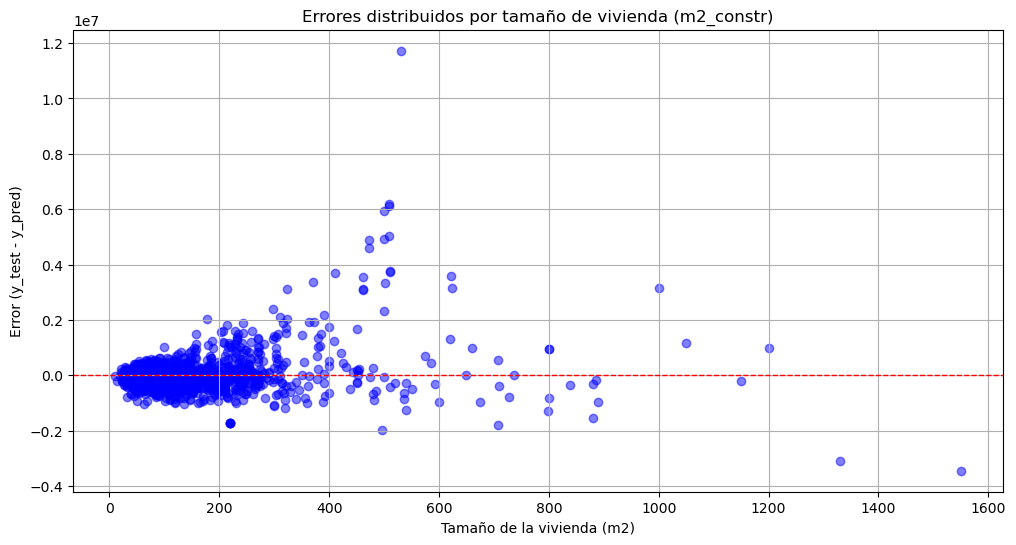

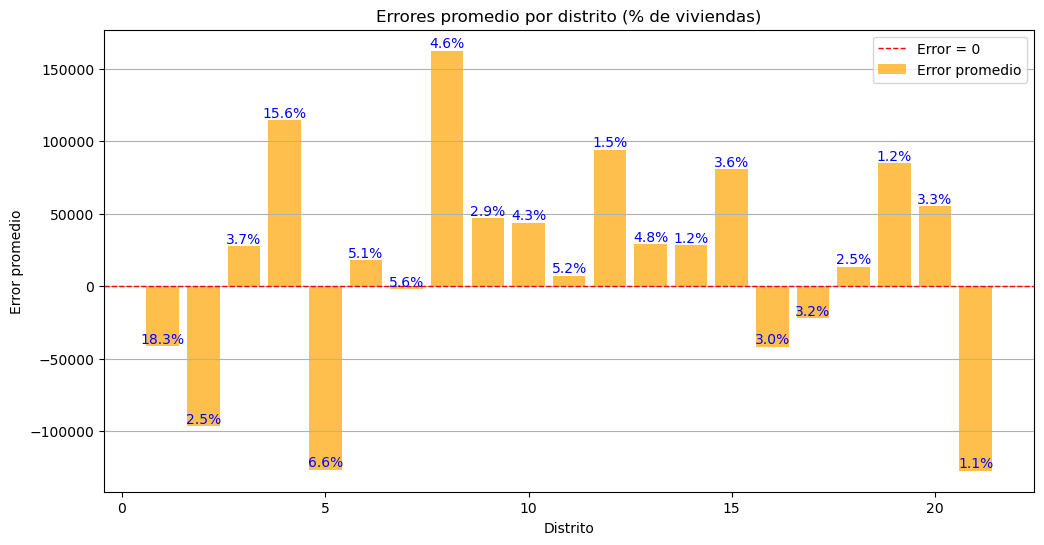

In [59]:
# Supongamos que tienes este DataFrame con los resultados
# df contiene las columnas: 'y_test', 'y_pred', 'm2_constr', 'cod_distrito'
df['error'] = df['y_test'] - df['y_pred']  # Calcular el error (residuo)

# Gráfico 1: Errores distribuidos por tamaño de vivienda (m2_constr)
plt.figure(figsize=(12, 6))
plt.scatter(df['m2_constr'], df['error'], alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Línea en error = 0
plt.title('Errores distribuidos por tamaño de vivienda (m2_constr)')
plt.xlabel('Tamaño de la vivienda (m2)')
plt.ylabel('Error (y_test - y_pred)')
plt.grid(True)
plt.show()

# Gráfico 2: Errores promedio por distrito


# Calcular el error promedio por distrito
error_district = df.groupby('cod_distrito')['error'].mean().reset_index()
# Calcular el porcentaje de viviendas en cada distrito
district_counts = df['cod_distrito'].value_counts(normalize=True) * 100 
district_counts = district_counts.reset_index()
district_counts.columns = ['cod_distrito', 'percentage']

# Unir el porcentaje al DataFrame de errores
error_district = error_district.merge(district_counts, on='cod_distrito')

# Gráfico de errores promedio por distrito con porcentaje
plt.figure(figsize=(12, 6))
bars = plt.bar(error_district['cod_distrito'], error_district['error'], color='orange', alpha=0.7, label='Error promedio')

# Anotar el porcentaje de viviendas en cada barra
for bar, pct in zip(bars, error_district['percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10, color='blue')

plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Error = 0')  # Línea de referencia
plt.title('Errores promedio por distrito (% de viviendas)')
plt.xlabel('Distrito')
plt.ylabel('Error promedio')
plt.legend()
plt.grid(axis='y')
plt.show()



Por ultimo mostramos la curva de aprendizaje del modelo

## *5.6 Curva de aprendizaje*

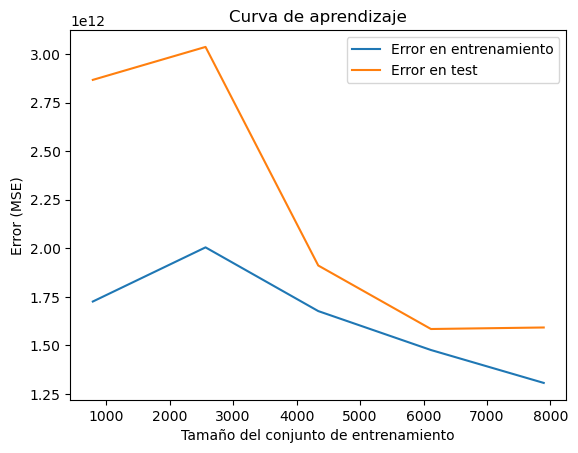

In [49]:

# Concatenamos los conjuntos de datos sin valores nulos
X = pd.concat([X_train_imputado, X_val_imputado, X_test_imputado])


train_sizes, train_scores, test_scores = learning_curve(lm, X, y, cv=5, scoring='neg_mean_squared_error')
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Error en entrenamiento')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Error en test')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error (MSE)")
plt.legend()
plt.title("Curva de aprendizaje")
plt.show()


La gráfica representa la **Curva de Aprendizaje**, donde el eje X muestra el **Tamaño del conjunto de entrenamiento** y el eje Y el **Error (MSE)**. 
La linea del error en entrenamiento comienza relativamente bajo,sube y-un poco para luego seguir bajando al ir aumentando los datos ,lo que el modelo indica que el modelo tiene un buen ajuste a los datos de entrenamiento , y es capaz de capturara patrones 
El error en test comienza muy alto  y decrece drásticamente con el aumento del tamaño del conjunto de entrenamiento.Finalmente se estabiliza , aunque al final parece que empieza a crecer muy ligeramente.
El modelo parece mejorar su rendimiento en los datos de test al aumentar el tamaño del conjunto de entrenamiento. Esto es una buena señal, ya que indica que no está sobreajustándose y que más datos ayudan a una mejor generalización.

# *6. Conclusion*


### Análisis Baseline del Dataset

En este análisis, se construyó un modelo **baseline** como punto de partida para un análisis más profundo del conjunto de datos. Se realizaron varias transformaciones iniciales para entrenar este modelo:

1. **Eliminación de variables categóricas**: Nos quedamos únicamente con las variables numéricas para entrenar un modelo de regresión lineal utilizando la librería `sklearn`.

2. **Eliminación de columnas con valores nulos excesivos**: Se descartaron aquellas columnas que tenían más del 80 % de valores nulos.

2. **Eliminación de columnas con mucha correlacion entre ellas**: Se eliminaron aquellas columnas que tenian otra varaible con una correlacción mayor al 90% con ella misma. aquellas columnas que tenían más del 80 % de valores nulos.

3. **Imputación de valores nulos**: Los valores faltantes fueron imputados agrupando los datos por `cod_barrio_group` y utilizando las medias calculadas por grupo.  
   - **`cod_barrio_group`** es una columna que clasifica los barrios en cinco categorías ordinales basadas en el precio promedio de las viviendas, generado mediante la función `pd.qcut()`:
     - Grupo 1: barrios con las viviendas más baratas.
     - Grupo 5: barrios con las viviendas más caras.

4. **División en conjuntos de entrenamiento, validación y prueba**: Para garantizar que los conjuntos incluyan una distribución heterogénea de viviendas (diferentes barrios y precios), se creó una variable clasificando los barrios en cinco grupos según su precio promedio. Esto asegura una representación diversa en los subconjuntos de datos.



### Métricas del Modelo Baseline
Sin realizar tratamientos adicionales, se entrenó un modelo de **Regresión Lineal**, obteniendo las siguientes métricas en el conjunto de entrenamiento:
- **R²**: 0.6768
- **MAE**: 330,554.04
- **MSE**: 432,693,343,364.66
- **RMSE**: 657,794.330 


Al analizar los valores que el modelo no predice correctamente en el entrenamiento, encontramos los siguientes puntos relevantes:
- El **75 % de los valores no predichos** están en los distritos del 1 al 7, lo que podría explicarse por el porcentaje elevado de viviendas en esos distritos dentro del dataset.
- El valor mínimo de **m2_constr** (100 m²) sugiere que el modelo tiene dificultades para predecir precios de viviendas con superficies grandes.Además se realiza un grafico de dispersion para ver como se distribuyen los error con respecto al precio y efectivamente muestra que el modelo parece tener un buen rendimiento general para viviendas de tamaño pequeño o medio pero para viviendas grandes, los errores son más significativos, lo que podría reflejar una falta de características específicas en el modelo, insuficiencia de datos de entrenamiento para este segmento o relaciones no lineales que el modelo lineal no logra captar.


### Mejoras para el Modelo
Para optimizar este modelo inicial, realizaremos las siguientes acciones:
1. **Revisión de características**: Incluir variables categóricas y transformar las existentes para enriquecer el modelo y analizar las caracteristicas de las viviendas grandes con mayores errores para identificar si existen patrones (por ejemplo, ubicaciones específicas, precios desproporcionados,etc.)
2. **Exploración de modelos más complejos**: Probar algoritmos que capturen mejor las relaciones no lineales en los datos.
3. **Normalización o estandarización de variables**: Esto podría estabilizar los coeficientes y mejorar el rendimiento del modelo.

